In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Data Analysis

In [2]:
df = pd.read_csv(r'C:\Users\ABHIJIT FLOYD\OneDrive\Desktop\Documents\Internship\AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df['Month'] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [5]:
df = df.set_index("Month")
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


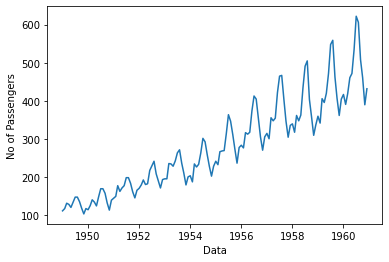

In [6]:
plt.xlabel("Data")
plt.ylabel("No of Passengers")
plt.plot(df)

In [7]:
def plot_graph(timeseries):
    rolling_avg = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    original_data = plt.plot(timeseries, label="Original Data")
    mean = plt.plot(rolling_avg, label="Rolling Mean")
    std = plt.plot(rolling_std, label="Rolling Std")

    plt.legend(loc="best")
    plt.title("Time Series Data with rolling mean and std")
    plt.show

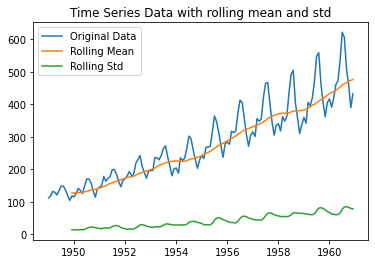

In [9]:
plot_graph(df)

### 1) It can be seen that the rolling average is not constant
### 2) Standard deviation is fairly constant with time
### 3) For our time series to be stationary, we need to ensure that both remain time invariant or constant

In [10]:
def check_if_data_is_stationary(ts_data):
    df_test = adfuller(ts_data)
    output = pd.Series(df_test[0:4], index=["Test statistic","p-value", "usedlag", "NOBS" ])
    
    print(output)

In [11]:
check_if_data_is_stationary(df)

Test statistic      0.815369
p-value             0.991880
usedlag            13.000000
NOBS              130.000000
dtype: float64


#### Null hypothesis is that the data is not stationary. To reject it, we should have p-value less than 0.05.

From p-value 0.99 we can easily see that the data is not stationary. We would use different techniques to reduce variance and make the data stationary

# Preprocessing

Test statistic     -1.717017
p-value             0.422367
usedlag            13.000000
NOBS              130.000000
dtype: float64


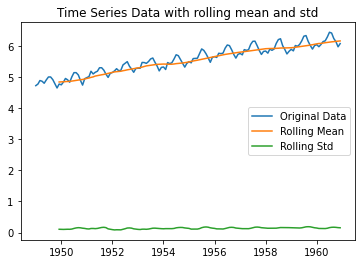

In [12]:
#log scale to reduce variance
log_scaled_df = np.log(df)

plot_graph(log_scaled_df)

check_if_data_is_stationary(log_scaled_df)

It can be observed that the rolling mean variance has reduced to one and the standard deviation is more constant

Test statistic     -3.162908
p-value             0.022235
usedlag            13.000000
NOBS              119.000000
dtype: float64


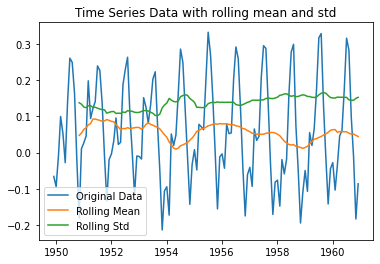

In [13]:
# log scaled data, moving average subtracted
log_scaled_df_rolling_mean = log_scaled_df.rolling(window=12).mean()
scaled_data = log_scaled_df - log_scaled_df_rolling_mean
scaled_data.dropna(inplace=True)

plot_graph(scaled_data)
check_if_data_is_stationary(scaled_data)

It can be seen from the p-value that the data is now stationary.

Now the data is ready to be used in any statistical model

Test statistic     -2.717131
p-value             0.071121
usedlag            14.000000
NOBS              128.000000
dtype: float64


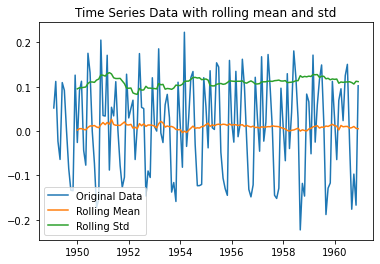

In [14]:
# period shift
ps_data = log_scaled_df.diff(periods=1)
ps_data.dropna(inplace=True)

plot_graph(ps_data)
check_if_data_is_stationary(ps_data)

As it can be seen, the p-value is not in the acceptable range. In this case, period shift doesn't give us stationary data.

So we will move forward with log scaled data with moving average subtracted

Let's try to reduce the window size and see if we can get an optimal value

Test statistic     -3.040034
p-value             0.031321
usedlag            11.000000
NOBS              130.000000
dtype: float64


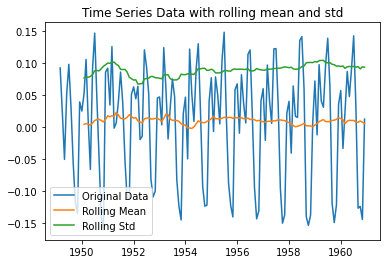

In [15]:
# log scaled data, moving average subtracted
log_scaled_df_rolling_mean = log_scaled_df.rolling(window=3).mean()
scaled_data = log_scaled_df - log_scaled_df_rolling_mean
scaled_data.dropna(inplace=True)

plot_graph(scaled_data)
check_if_data_is_stationary(scaled_data)

So we got our desired value < 0.05 at window = 3

C:\Users\ABHIJIT FLOYD\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


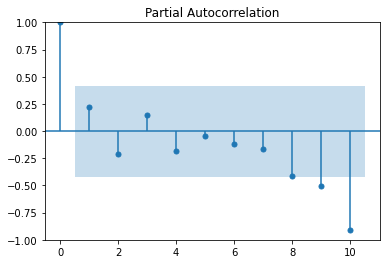

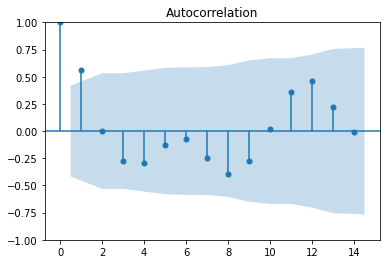

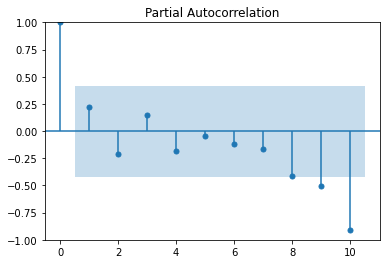

In [16]:
# plotting acf and pcf
lag_acf = acf(scaled_data)
lag_pacf = pacf(scaled_data)

plot_acf(lag_acf)
plot_pacf(lag_pacf, lags=10)

#### 1) Moving Average (q value) = 2 (from acf graph)
#### 2) Auto-regressive (p value) = 1 (from pacf graph)
#### 3) ifferentiation (d value) = 2 (from the window, period value)

We have now removed the ets (error, trend, seasonality

# Model Training

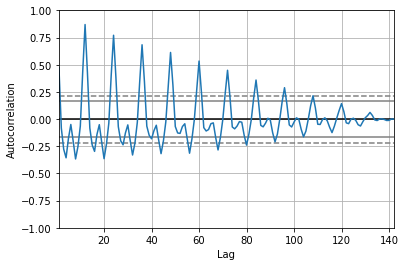

In [17]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(scaled_data)
plt.show()

In [18]:
train, test = train_test_split(scaled_data, test_size=0.1, shuffle=False)
model_arima = ARIMA(train, order=(15,2,1))
model_fit = model_arima.fit()

C:\Users\ABHIJIT FLOYD\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ABHIJIT FLOYD\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ABHIJIT FLOYD\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ABHIJIT FLOYD\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ABHIJIT FLOYD\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserW

<AxesSubplot:ylabel='Density'>

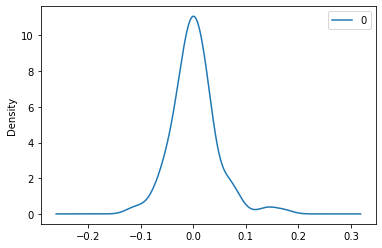

In [19]:
residual = pd.DataFrame(model_fit.resid)
residual.plot(kind="kde")

It can be observed that the peak is narrowing arround 0. The closer a data point's residual is to 0, the better the fit.

# Prediction

In [20]:
preds = model_fit.predict(start='1959-10-01', end='1960-12-01')

# Evaluation

In [21]:
from sklearn.metrics import r2_score, mean_squared_error

score = r2_score(test, preds)
error = mean_squared_error(test, preds)

print(f"R2 score: {score}")
print(f"Mean squared error: {error:.5f}")

R2 score: 0.9331768491560791
Mean squared error: 0.00059


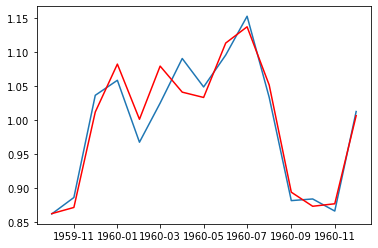

In [22]:
test_set = np.exp(test)
predictions = np.exp(preds)

plt.plot(test_set)
plt.plot(predictions, color="red")
plt.show()

We tried a range of p values (0 to 20) it can be observed that the model is giving 92% accurate predictions at p value = 15